### Imports & Configs

In [2]:
import matplotlib.pyplot as plt
import torch
import timm
import os
import cv2
import numpy as np
import mlflow
import copy
import pandas as pd
import seaborn as sns

from torch.nn import functional as F
from torchvision import transforms
from torchinfo import summary
from avalanche.evaluation.metrics.accuracy import Accuracy
from timm.scheduler.cosine_lr import CosineLRScheduler
from timm.models import create_model
from tqdm import tqdm
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.colors import ListedColormap

# Custom imports
from src.model import VisionTransformerWithCustomHead
from src.data.data_handler import BrainTumorDataHandler
from src.data.brain_dataset import CustomBrainTumorDataset
from src.data.augmentation import CenterCropPercentage
from src.utils import set_seeds, log_to_mlflow

plt.style.use('seaborn-v0_8-whitegrid')


In [3]:
# Optional device configuration
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Device configuration on Apple silicon (e.g. M1) or AMD GPUs using Metal Performance Shaders (MPS)
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
#device = torch.device('cpu')

# Set seeds for reproducibility
set_seeds(42)

# Dataset paths
TRAIN_DIR = './src/data/train'
TEST_DIR = './src/data/test'

# Training parameters
NUM_WORKERS = min(4, os.cpu_count()) # Maximum of 4 workers
TRAIN_VAL_SPLIT = 0.8
BATCH_SIZE = 128
EPOCHS = 20
PIN_MEMORY = False

### Data Overview

In [9]:
def count_samples(directory: str):
    '''
    Count the number of samples/files in a directory.

    Args:
    -----
    directory: str
        Directory to count samples in.

    Returns:
    --------
    _ : int
        Number of samples in the directory.
    '''
    return sum(len(files) for _, _, files in os.walk(directory))


classes = os.listdir(TRAIN_DIR)
n_train = count_samples(TRAIN_DIR)
n_test = count_samples(TEST_DIR)

# Overview of the dataset
print(f'{len(classes)} Classes: {classes}')
print(f'{n_train} Training samples')
print(f'{n_test} Test samples')


4 Classes: ['pituitary', 'notumor', 'glioma', 'meningioma']
5712 Training samples
1311 Test samples


In [4]:
def count_samples_by_class(directory: str, classes: list):
    '''
    Count the number of samples/files in a directory for each class.

    Args:
    -----
    directory: str
        Directory to count samples in.
    classes: list
        List of class names.

    Returns:
    --------
    counts : list
        List of counts for each class.
    '''
    counts = []
    for label in classes:
        path = os.path.join(directory, label)
        count = sum(len(files) for _, _, files in os.walk(path))
        counts.append(count)
    return counts

# Count samples by class
train_counts = count_samples_by_class(TRAIN_DIR, classes)
test_counts = count_samples_by_class(TEST_DIR, classes)

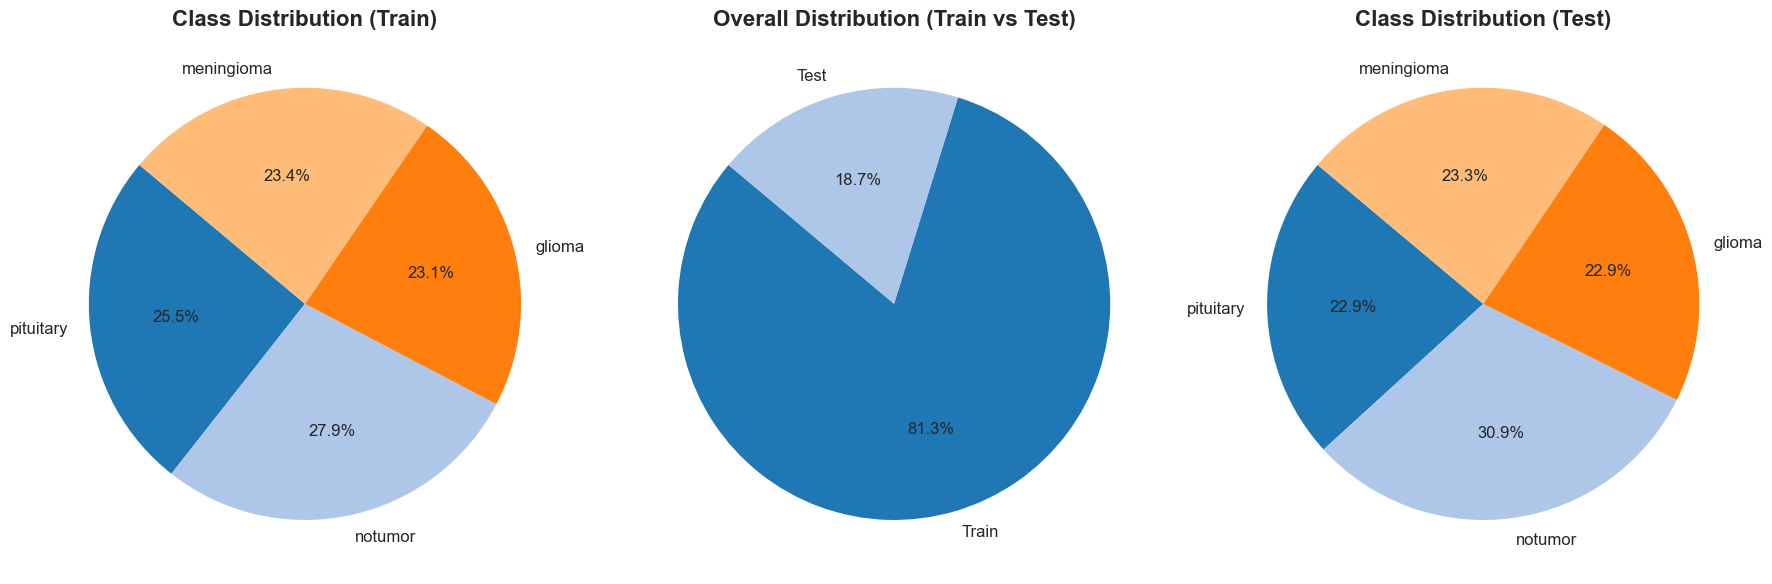

In [5]:
title_font = {'fontsize': 16, 'fontweight': 'bold'}
label_font = {'fontsize': 12}
autopct_font = {'fontsize': 10, 'fontweight': 'bold'}

fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 

colors = plt.get_cmap('tab20').colors 

# Class Distribution in Training Set 
axs[0].pie(train_counts, labels=classes, autopct='%1.1f%%', startangle=140, colors=colors, textprops=label_font)
axs[0].set_title('Class Distribution (Train)', fontdict=title_font)

# Overall Distribution (Train vs Test)
axs[1].pie([n_train, n_test], labels=['Train', 'Test'], autopct='%1.1f%%', startangle=140, colors=colors[:2], textprops=label_font)
axs[1].set_title('Overall Distribution (Train vs Test)', fontdict=title_font)

# Class Distribution in Test Set
axs[2].pie(test_counts, labels=classes, autopct='%1.1f%%', startangle=140, colors=colors, textprops=label_font)
axs[2].set_title('Class Distribution (Test)', fontdict=title_font)

plt.tight_layout()  
plt.show()

In [6]:
def get_image_shapes(directory):
    '''
    Get the distribution of image shapes in a directory.

    Args:
    -----
    directory: str
        Directory containing the images.

    Returns:
    --------
    shape_distribution: dict
        Dictionary containing the distribution of image shapes.
    '''
    shape_distribution = {}
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                try:
                    filepath = os.path.join(subdir, file)
                    with Image.open(filepath) as img:
                        shape = img.size  
                        if shape in shape_distribution:
                            shape_distribution[shape] += 1
                        else:
                            shape_distribution[shape] = 1
                except Exception as e:
                    print(f"Error opening {filepath}: {e}")

    return shape_distribution

image_sizes = get_image_shapes(TRAIN_DIR)

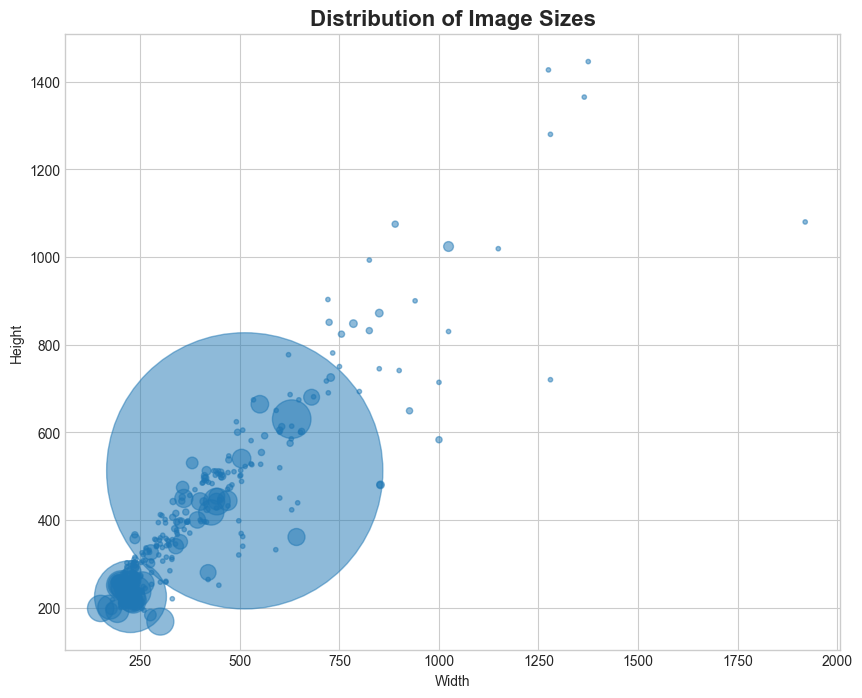

In [7]:
widths = [size[0] for size in image_sizes.keys()]
heights = [size[1] for size in image_sizes.keys()]
counts = [count for count in image_sizes.values()]

plt.figure(figsize=(10, 8))
plt.scatter(widths, heights, s=np.array(counts) * 10, alpha=0.5) 
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Distribution of Image Sizes', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.grid(True)

plt.show()

### Data Augmentation & Normalization

In [5]:
# Data Augmentation and Normalization 
CROP_PERCENTAGE = 80
CROP_SIZE = (320, 320)
RESIZE_SIZE = (224, 224)
MEAN_IMAGENET = [0.485, 0.456, 0.406]
STD_IMAGENET = [0.229, 0.224, 0.225]

# Training/Validation set transformations
train_transforms = transforms.Compose([
            #transforms.CenterCrop(CROP_SIZE),
            CenterCropPercentage(CROP_PERCENTAGE),
            transforms.Resize(RESIZE_SIZE, interpolation=3),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN_IMAGENET, std=STD_IMAGENET)
        ])  

# Test set transformations
test_transforms = transforms.Compose([
            #transforms.CenterCrop(CROP_SIZE),
            CenterCropPercentage(CROP_PERCENTAGE),
            transforms.Resize(RESIZE_SIZE, interpolation=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN_IMAGENET, std=STD_IMAGENET)
        ])  


# Create datasets from directories
#train_data = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
#test_data = datasets.ImageFolder(TEST_DIR, transform=test_transforms)

train_data = CustomBrainTumorDataset(TRAIN_DIR, transform=train_transforms)
test_data = CustomBrainTumorDataset(TEST_DIR, transform=test_transforms)

CLASSES = train_data.classes
N_CLASSES = len(CLASSES)
CLASS_INDICES = train_data.class_to_idx
INDICES_CLASS = {v: k for k, v in CLASS_INDICES.items()}

In [6]:
# Initialize the BrainTumorData class
brain_data = BrainTumorDataHandler(train_data, test_data, TRAIN_VAL_SPLIT, BATCH_SIZE, NUM_WORKERS, PIN_MEMORY)

# Get the data loaders for training, validation and testing
train_loader, val_loader, test_loader = brain_data.get_loaders()

### Model initialization

In [10]:
# Pretrained model backbone name from timm
MODEL_NAME = 'vit_base_patch16_224'

# Instantiate the custom model
custom_vit = VisionTransformerWithCustomHead(MODEL_NAME, N_CLASSES)

In [11]:
summary(model=custom_vit, 
        input_size=(32, 3, 224, 224), 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        )

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Trainable
VisionTransformerWithCustomHead               [32, 3, 224, 224]    [32, 4]              --                   Partial
├─VisionTransformer: 1-1                      [32, 3, 224, 224]    [32, 768]            152,064              False
│    └─PatchEmbed: 2-1                        [32, 3, 224, 224]    [32, 196, 768]       --                   False
│    │    └─Conv2d: 3-1                       [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
│    │    └─Identity: 3-2                     [32, 196, 768]       [32, 196, 768]       --                   --
│    └─Dropout: 2-2                           [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Identity: 2-3                          [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Identity: 2-4                          [32, 197, 768]       [32, 197, 768]  

### Model Training

In [12]:
def train(model, train_loader, val_loader, opt, scheduler, lr, batch_size, epoch=10):
    '''
    Trains and evaluates the model on the train and validation set with specified optimizer and scheduler. For
    each epoch, the model accuracy and loss is logged to MLFlow together with the learning rate and batch size.

    Args:
    -----
    model: nn.Module
        The model to be trained
    train_loader: DataLoader
        The DataLoader containing the training data
    val_loader: DataLoader
        The DataLoader containing the validation data
    opt: torch.optim.Optimizer
        The optimizer to be used for training
    scheduler: torch.optim.lr_scheduler
        The learning rate scheduler to be used
    lr: float
        The learning rate
    batch_size: int
        The batch size  
    '''

    for ep in tqdm(range(epoch)):
        model.train()
        train_acc = Accuracy()
        total_loss = 0
        for feature, label in train_loader:
            feature, label = feature.to(device), label.to(device)
            out = model(feature)
            loss = F.cross_entropy(out, label)
            opt.zero_grad()
            loss.backward()
            opt.step()

            train_acc.update(out.argmax(dim=1).view(-1), label)
            total_loss += loss.item()

        scheduler.step(ep)

        train_acc = train_acc.result()
        train_loss = total_loss / len(train_loader)
        val_acc, val_loss = test(model, val_loader)

        log_to_mlflow(model, train_acc, train_loss, val_acc, val_loss, ep, lr, batch_size)

    return train_acc, val_acc


@torch.no_grad()
def test(model, loader):
    '''
    Validates the model on the given data loader and returns the accuracy and average loss.

    Args:
    -----
    model: nn.Module
        The model to be evaluated
    loader: DataLoader
        The DataLoader containing the validation data

    Returns:
    --------
    acc: float
        The validation accuracy of the model
    avg_loss: float
        The average validation loss of the model
    '''
    model.eval()
    acc = Accuracy()
    total_loss = 0

    for feature, label in loader:  
        feature, label = feature.to(device), label.to(device)
        out = model(feature)
        acc.update(out.argmax(dim=1).view(-1), label)
        loss = F.cross_entropy(out, label)
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)

    return acc.result(), avg_loss

In [13]:
# Hyperparameters to use for training (only learning rate for demonstration purposes)
params = {
    'learning_rate': np.logspace(-4, -2, 3)
}

# Training loop
for lr in params['learning_rate']:
    with mlflow.start_run():
        
        model = copy.deepcopy(custom_vit)
        model.to(device)

        optimizer = torch.optim.Adam(params=model.parameters(),
                                 lr=lr, weight_decay=0.001)
        
        scheduler = CosineLRScheduler(optimizer, t_initial=100,
                                  warmup_t=10, lr_min=1e-5, warmup_lr_init=1e-6)

        train_acc, train_loss = train(model, train_loader, val_loader, optimizer, 
                                      scheduler, lr, BATCH_SIZE, EPOCHS)

  0%|          | 0/20 [00:00<?, ?it/s]Successfully registered model 'brain-tumor-model-0-0.0001'.
Created version '1' of model 'brain-tumor-model-0-0.0001'.
  5%|▌         | 1/20 [04:21<1:22:39, 261.04s/it]Successfully registered model 'brain-tumor-model-1-0.0001'.
Created version '1' of model 'brain-tumor-model-1-0.0001'.
 10%|█         | 2/20 [09:01<1:21:39, 272.18s/it]Successfully registered model 'brain-tumor-model-2-0.0001'.
Created version '1' of model 'brain-tumor-model-2-0.0001'.
 15%|█▌        | 3/20 [14:41<1:25:57, 303.39s/it]Successfully registered model 'brain-tumor-model-3-0.0001'.
Created version '1' of model 'brain-tumor-model-3-0.0001'.
 20%|██        | 4/20 [20:12<1:23:49, 314.35s/it]Successfully registered model 'brain-tumor-model-4-0.0001'.
Created version '1' of model 'brain-tumor-model-4-0.0001'.
 25%|██▌       | 5/20 [26:07<1:22:15, 329.04s/it]Successfully registered model 'brain-tumor-model-5-0.0001'.
Created version '1' of model 'brain-tumor-model-5-0.0001'.
 30

### Testing & Evaluation

In [7]:
# Load the best model
best_model_name = "brain-tumor-model-18-0.001"
best_model_version = 1

best_model = mlflow.pytorch.load_model(model_uri=f'models:/{best_model_name}/{best_model_version}')

In [10]:
# Dictionary to store the correct predictions for each class
correct_pred = {classname: 0 for classname in CLASSES}
total_pred = {classname: 0 for classname in CLASSES}

# Lists to store all labels and predictions
all_labels = []
all_predictions = []

# Evaluation of the best model on the test set
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = best_model(features)
        _, predictions = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

        # Count correct predictions per class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# Per Class Accuracy
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

conf_matrix = confusion_matrix(all_labels, all_predictions)

# Classification report
classification_report_str = classification_report(all_labels, all_predictions, target_names=CLASSES)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report_str)

Accuracy for class: glioma is 99.8 %
Accuracy for class: meningioma is 98.7 %
Accuracy for class: notumor is 97.4 %
Accuracy for class: pituitary is 83.3 %
Confusion Matrix:
[[250  46   0   4]
 [  3 298   2   3]
 [  0   1 404   0]
 [  0   4   0 296]]

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.83      0.90       300
  meningioma       0.85      0.97      0.91       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.98      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



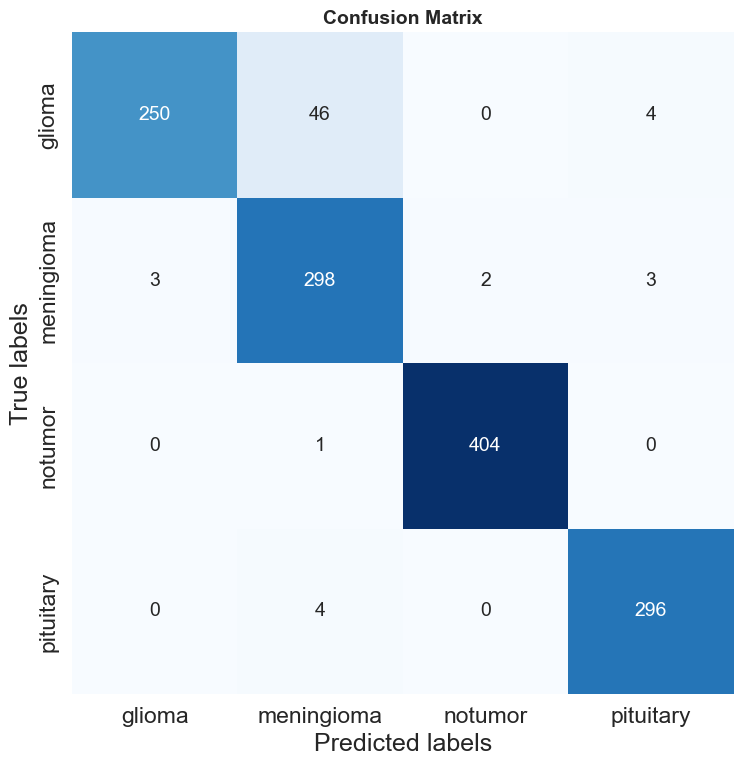

In [11]:
# Plot of the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.set_theme(font_scale=1.5)  # for label size
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 14}, fmt='d', cmap='Blues', cbar=False, square=True)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax.xaxis.set_ticklabels(['glioma', 'meningioma', 'notumor', 'pituitary'])
ax.yaxis.set_ticklabels(['glioma', 'meningioma', 'notumor', 'pituitary'])

plt.tight_layout()
plt.show()

In [17]:
# Dummy Classifier

def get_all_batches(dataloader):
    '''
    Get all batches from a DataLoader and concatenate them into a single numpy array.

    Args:
    -----
    dataloader: DataLoader
        The DataLoader to get all batches from.

    Returns:
    --------
    all_X: np.array
        The concatenated feature arrays from all batches.
    all_y: np.array
        The concatenated label arrays from all batches.
    '''

    all_X, all_y = [], []
    for data in dataloader:
        inputs, labels = data
        all_X.append(inputs.numpy()) 
        all_y.append(labels.numpy())

    return np.concatenate(all_X), np.concatenate(all_y)

X_test, y_test = get_all_batches(test_loader)
X_train, y_train = get_all_batches(train_loader)

# Initialize the dummy classifier
dummy_clf = DummyClassifier(strategy='uniform', random_state=42)
dummy_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = dummy_clf.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print('Classfication Report:', classification_report(y_test, y_pred, target_names=CLASSES))

Confusion Matrix:
 [[ 74  68  77  81]
 [ 69  72  71  94]
 [121  91  85 108]
 [ 82  83  80  55]]
Classfication Report:               precision    recall  f1-score   support

      glioma       0.21      0.25      0.23       300
  meningioma       0.23      0.24      0.23       306
     notumor       0.27      0.21      0.24       405
   pituitary       0.16      0.18      0.17       300

    accuracy                           0.22      1311
   macro avg       0.22      0.22      0.22      1311
weighted avg       0.22      0.22      0.22      1311



### Visualizations

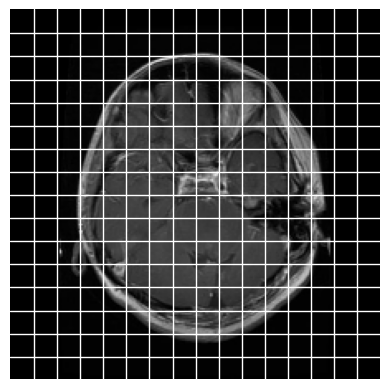

In [21]:
# Plot of ViT patches
img = cv2.imread('./src/data/test/glioma/Te-gl_0010.jpg')
img = cv2.resize(img, (224,224))

tiles_per_dim = 16 
img_height, img_width, _ = img.shape
tile_height = img_height // tiles_per_dim
tile_width = img_width // tiles_per_dim

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray') 

for i in range(1, tiles_per_dim):
    ax.axhline(y=i * tile_height, color='white', linewidth=1)
    ax.axvline(x=i * tile_width, color='white', linewidth=1)

ax.set_axis_off()  
plt.show()

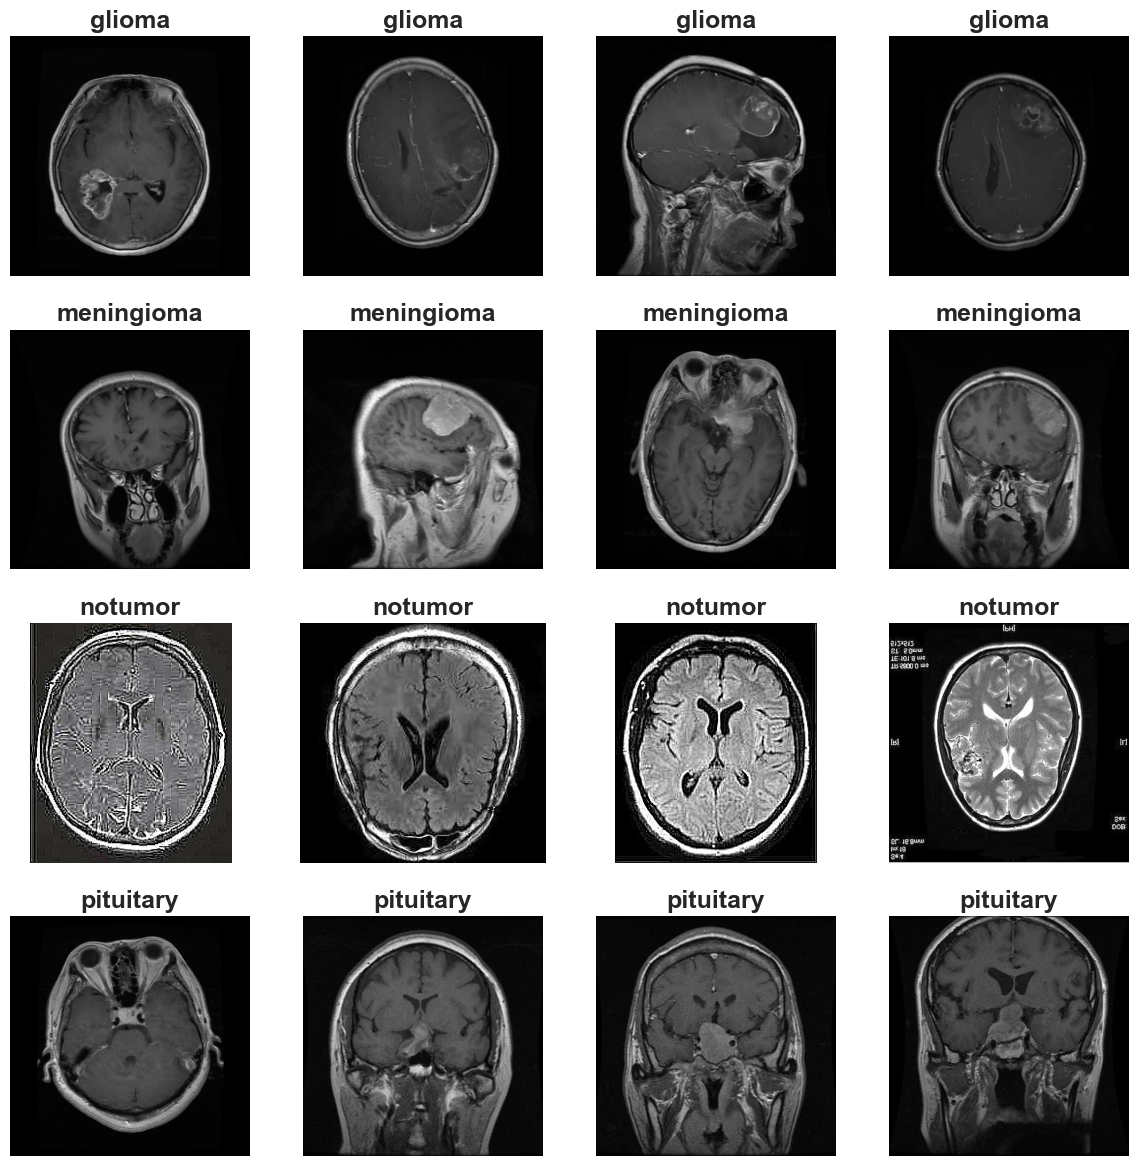

In [22]:
# Plot of four samples from each class
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12)) 
axes = axes.ravel()

index = 0
for class_name in CLASSES:
    folder_path = os.path.join(TRAIN_DIR, class_name)
    images = os.listdir(folder_path)[:4] 

    for image_name in images:
        image_path = os.path.join(folder_path, image_name)
        img = Image.open(image_path)
        img_data = np.array(img, dtype=np.uint8)  
        axes[index].imshow(img_data, cmap='gray')  
        axes[index].set_title(f'{class_name}', fontweight='bold')
        axes[index].axis('off')
        index += 1

plt.tight_layout()
plt.show()

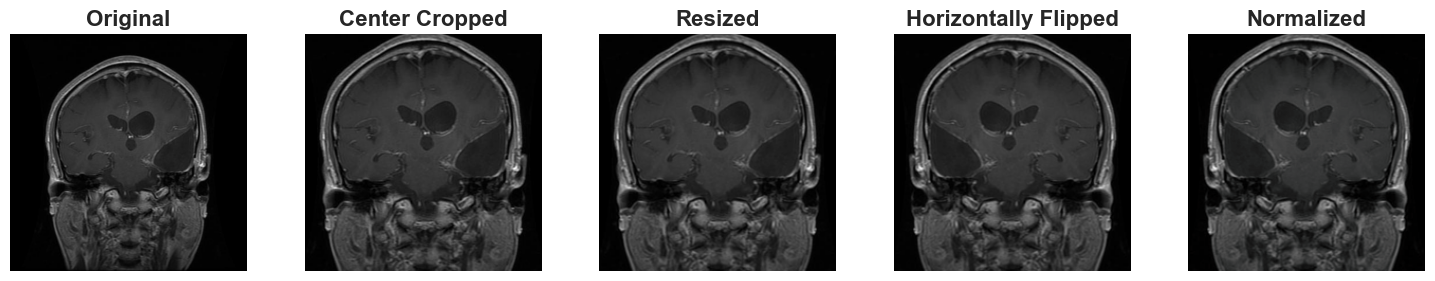

In [23]:
# Plot of the augmentation process
center_crop = CenterCropPercentage(CROP_PERCENTAGE)
resize = transforms.Resize(RESIZE_SIZE, interpolation=Image.BICUBIC)  
random_flip = transforms.RandomHorizontalFlip(p=1)  
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=MEAN_IMAGENET, std=STD_IMAGENET)

img_path = './src/data/train/glioma/Tr-gl_0012.jpg'
img = Image.open(img_path)

# Apply transformations
img_center_cropped = center_crop(img)
img_resized = resize(img_center_cropped)
img_flipped = random_flip(img_resized)
img_tensor = to_tensor(img_flipped)
img_normalized = normalize(img_tensor)

# Convert normalized image back to displayable form
img_normalized_disp = img_normalized.clone()
for i in range(3):
    img_normalized_disp[i] = img_normalized_disp[i] * STD_IMAGENET[i] + MEAN_IMAGENET[i]
img_normalized_disp = transforms.ToPILImage()(img_normalized_disp)

title_font = {'fontsize': 16, 'fontweight': 'bold'}
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
ax[0].imshow(img)
ax[0].set_title("Original", fontdict=title_font)
ax[0].axis('off')

ax[1].imshow(img_center_cropped)
ax[1].set_title("Center Cropped", fontdict=title_font)
ax[1].axis('off')

ax[2].imshow(img_resized)
ax[2].set_title("Resized", fontdict=title_font)
ax[2].axis('off')

ax[3].imshow(img_flipped)
ax[3].set_title("Horizontally Flipped", fontdict=title_font)
ax[3].axis('off')

ax[4].imshow(img_normalized_disp)
ax[4].set_title("Normalized", fontdict=title_font)
ax[4].axis('off')

plt.tight_layout()
plt.show()

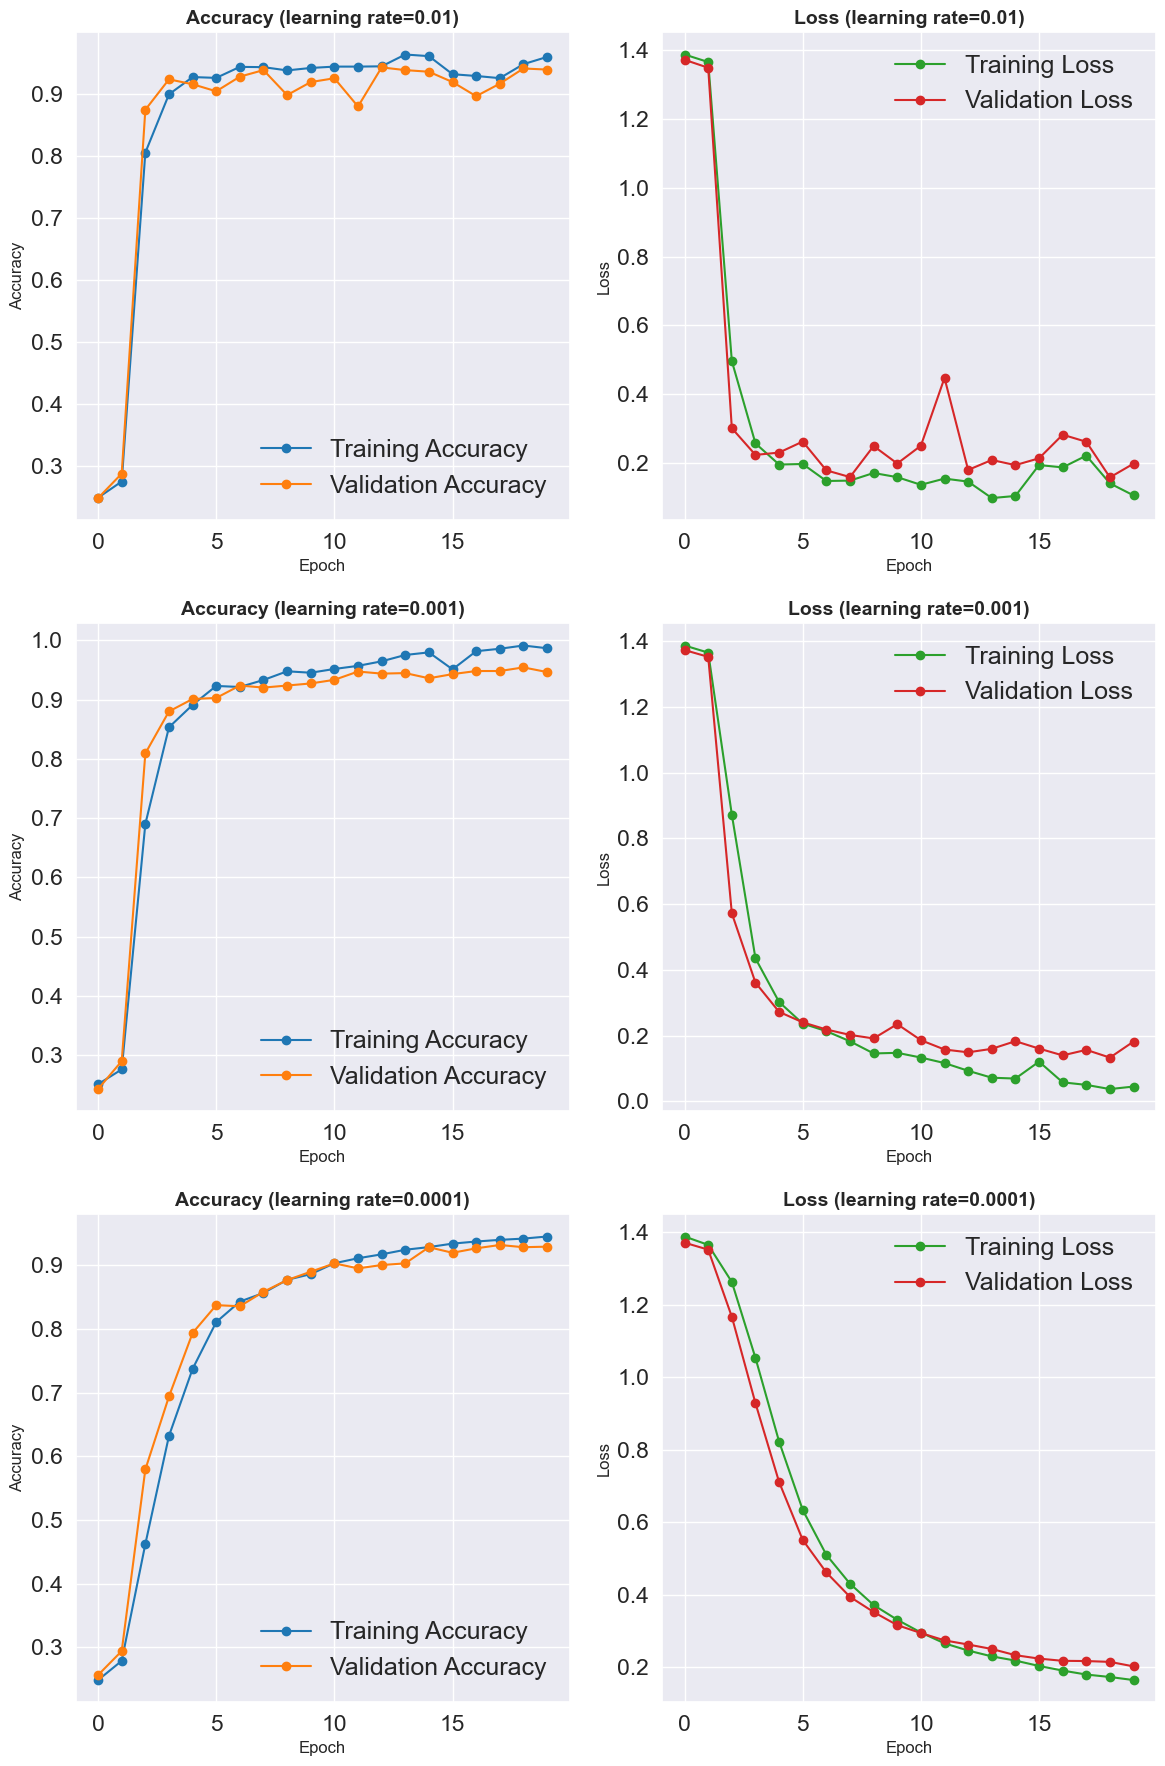

In [11]:
# Plot of the training and validation metrics (loss and accuracy)
REGISTRY = './mlruns'
client = mlflow.tracking.MlflowClient(
            tracking_uri=REGISTRY,
            registry_uri=REGISTRY,
        )

learning_rates = [0.01, 0.001, 0.0001]
mlflow_runids = ['4b26b90e24204bb59d5639499bd55e30', '300f7e2919394c3db477227bd3fbc92a', '2ba1a6c2fc4141029331980c92212bfd']
epochs = range(20)


training_accuracies = [[metric.value for metric in client.get_metric_history(runID, 'train_accuracy')] for runID in mlflow_runids]
validation_accuracies = [[metric.value for metric in client.get_metric_history(runID, 'val_accuracy')] for runID in mlflow_runids]
training_losses = [[metric.value for metric in client.get_metric_history(runID, 'train_loss')] for runID in mlflow_runids]
validation_losses = [[metric.value for metric in client.get_metric_history(runID, 'val_loss')] for runID in mlflow_runids]

fig, axs = plt.subplots(3, 2, figsize=(12, 18))

title_font = {'fontsize': 14, 'fontweight': 'bold'}
label_font = {'fontsize': 12}
colors = {
    'train_acc': '#1f77b4',  
    'val_acc': '#ff7f0e',   
    'train_loss': '#2ca02c',  
    'val_loss': '#d62728'  
}

for i, lr in enumerate(learning_rates):
    # Plot training and validation accuracy
    axs[i, 0].plot(epochs, training_accuracies[i], label='Training Accuracy', color=colors['train_acc'], marker='o')
    axs[i, 0].plot(epochs, validation_accuracies[i], label='Validation Accuracy', color=colors['val_acc'], marker='o')
    axs[i, 0].set_title(f'Accuracy (learning rate={lr})', fontdict=title_font)
    axs[i, 0].set_xlabel('Epoch', fontdict=label_font)
    axs[i, 0].set_ylabel('Accuracy', fontdict=label_font)
    axs[i, 0].legend(loc='lower right', fontsize='medium')

    # Plot training and validation loss
    axs[i, 1].plot(epochs, training_losses[i], label='Training Loss', color=colors['train_loss'], marker='o')
    axs[i, 1].plot(epochs, validation_losses[i], label='Validation Loss', color=colors['val_loss'], marker='o')
    axs[i, 1].set_title(f'Loss (learning rate={lr})', fontdict=title_font)
    axs[i, 1].set_xlabel('Epoch', fontdict=label_font)
    axs[i, 1].set_ylabel('Loss', fontdict=label_font)
    axs[i, 1].legend(loc='upper right', fontsize='medium')

plt.tight_layout()
plt.show()


In [ ]:
# Compute sample embeddings after processing through the ViT backbone
df = pd.DataFrame()
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
model.to(device)
model.eval()

for features, labels in test_loader:
    features, labels = features.to(device), labels.to(device) 
    embeddings = model(features) 
    
    temp_df = pd.DataFrame(embeddings.detach().cpu().numpy())
    temp_df['label'] = labels.cpu().numpy() 
    df = pd.concat([df, temp_df], ignore_index=True)

features = df.drop('label', axis=1).values 
labels = df['label'].values

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1311 samples in 0.001s...
[t-SNE] Computed neighbors for 1311 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1311
[t-SNE] Computed conditional probabilities for sample 1311 / 1311
[t-SNE] Mean sigma: 10.777514
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.222855
[t-SNE] KL divergence after 300 iterations: 1.473725


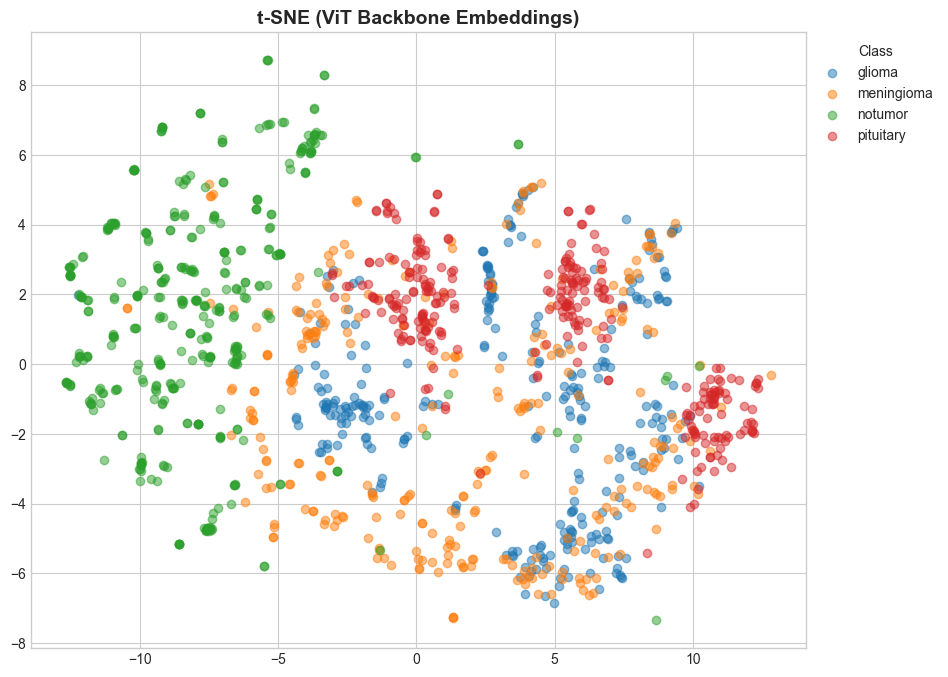

In [ ]:
# Plot the t-SNE visualization of the computed embeddings
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(features)

df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']   
cmap = ListedColormap(colors)
labels = df['label'].values
unique_labels = np.unique(labels)

plt.figure(figsize=(10, 8))

for i, label in enumerate(unique_labels):
    plt.scatter(df.loc[df['label'] == label, 'tsne-2d-one'], 
                df.loc[df['label'] == label, 'tsne-2d-two'],
                color=cmap(i),  
                label=INDICES_CLASS[label],  
                alpha=0.5)

plt.legend(title='Class', loc='upper left', bbox_to_anchor=(1, 1)) 
plt.title('t-SNE (ViT Backbone Embeddings)', fontdict=title_font)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1311 samples in 0.003s...
[t-SNE] Computed neighbors for 1311 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1311
[t-SNE] Computed conditional probabilities for sample 1311 / 1311
[t-SNE] Mean sigma: 1.645360
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.891716
[t-SNE] KL divergence after 300 iterations: 1.086850


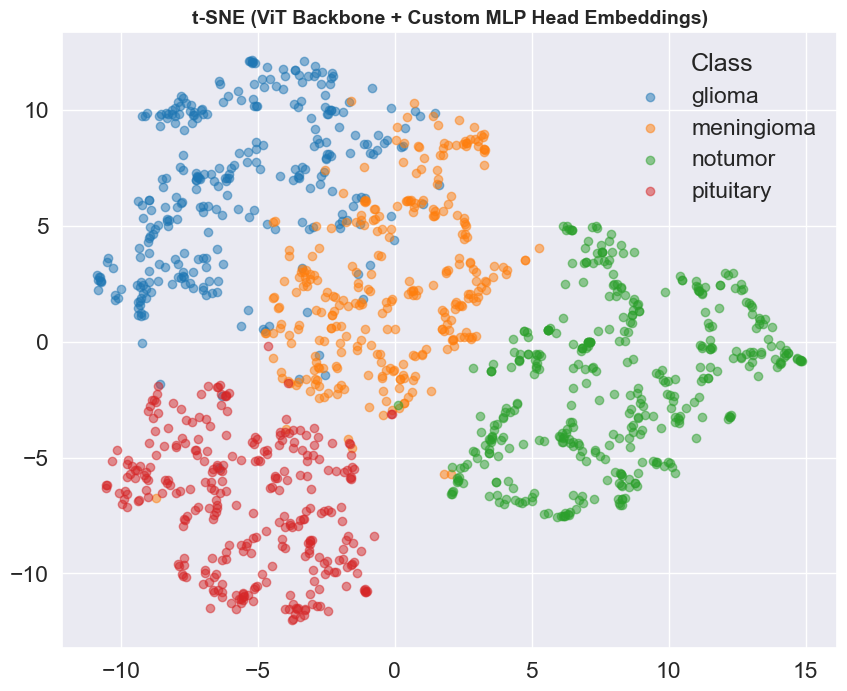

In [13]:
df2 = pd.DataFrame()
best_model.eval()

for features, labels in test_loader:  
    features, labels = features.to(device), labels.to(device) 
    embeddings = best_model(features) 
    
    temp_df = pd.DataFrame(embeddings.detach().cpu().numpy())
    temp_df['label'] = labels.cpu().numpy() 

    df2 = pd.concat([df2, temp_df], ignore_index=True)

features = df2.drop('label', axis=1).values  # Get the numerical values
labels = df2['label'].values

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(features)

df2['tsne-2d-one'] = tsne_results[:,0]
df2['tsne-2d-two'] = tsne_results[:,1]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']   # One color for each label
cmap = ListedColormap(colors)
labels = df2['label'].values
unique_labels = np.unique(labels)

# Plotting each class separately to create plot handles for the legend
plt.figure(figsize=(10, 8))

for i, label in enumerate(unique_labels):
    plt.scatter(df2.loc[df2['label'] == label, 'tsne-2d-one'], 
                df2.loc[df2['label'] == label, 'tsne-2d-two'],
                color=cmap(i),  # Map the color using the colormap
                label=INDICES_CLASS[label],  
                alpha=0.5)

plt.legend(title='Class', loc='best')
plt.title("t-SNE (ViT Backbone + Custom MLP Head Embeddings)", fontdict=title_font)
plt.show()

In [24]:
# Code by https://github.com/huggingface/pytorch-image-models/discussions/1232
# Computing the (class) attention maps for the last layer of the ViT model
def to_tensor(img):
    transform_fn = transforms.Compose([
            #transforms.CenterCrop(CROP_SIZE),
            CenterCropPercentage(CROP_PERCENTAGE),
            transforms.Resize(RESIZE_SIZE, interpolation=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN_IMAGENET, std=STD_IMAGENET)
        ])  
    return transform_fn(img)

def show_img(img):
    img = np.asarray(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)  

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 1:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

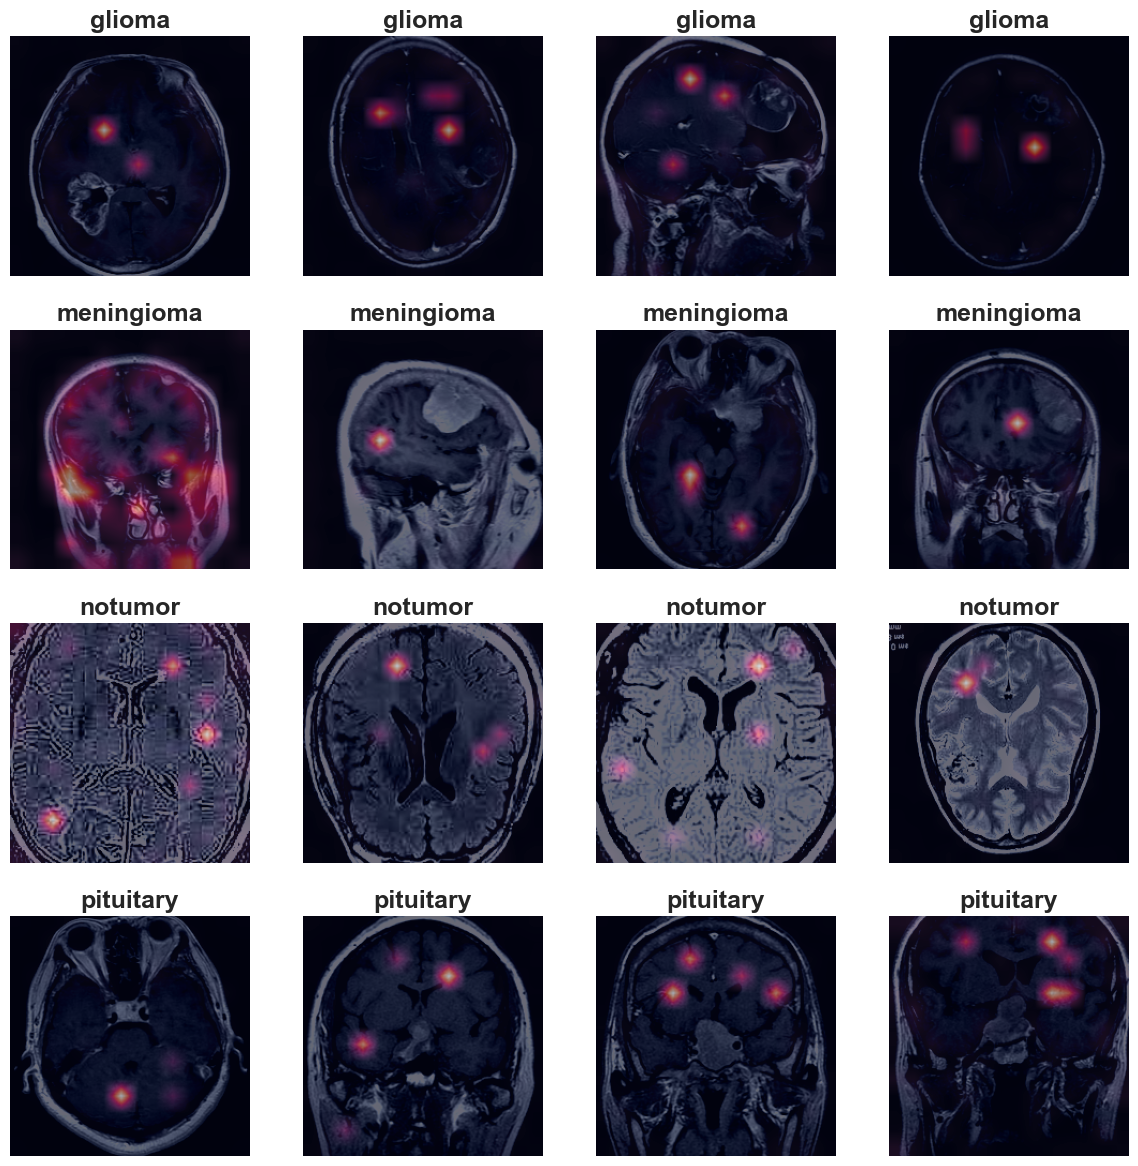

In [25]:
# Plot the (class) attention maps for the last layer of the ViT model - for four samples from each class
def show_img2(ax, img1, img2, alpha=0.8):
    if isinstance(img1, torch.Tensor):
        img1 = img1.numpy()
    if isinstance(img2, torch.Tensor):
        img2 = img2.numpy()

    ax.imshow(img1)
    ax.imshow(img2, alpha=alpha) 
    ax.axis('off')

model = create_model('vit_base_patch16_224', pretrained=True)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12)) 
axes = axes.ravel()

index = 0
for class_name in CLASSES:
    folder_path = os.path.join(TRAIN_DIR, class_name)
    images = os.listdir(folder_path)[:4] 

    for image_name in images:
        image_path = os.path.join(folder_path, image_name)

        img = Image.open(image_path, mode='r').convert('RGB')
        x = to_tensor(img)

        model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

        y = model(x.unsqueeze(0))
        attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
        cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

        img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
        cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

        show_img2(axes[index], img_resized, cls_resized, alpha=0.6)
        axes[index].set_title(f'{class_name}', fontweight='bold')
        axes[index].axis('off')
        index += 1

plt.tight_layout()
plt.show()